<a href="https://colab.research.google.com/github/poojan14/AIMS/blob/main/AIMS_residual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [2]:

download = drive.CreateFile({'id':'1UAdVNJYNEyUU3iGMQoQACNjrojqOHhVM'})


In [3]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
download.GetContentFile('AIMS.csv')
import pandas as pd
import numpy as np
df=pd.read_csv('AIMS.csv')
#We will deal with hourly predictions, so start by sub-sampling the data from 10 minute intervals to 1h:
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]
df['date_time']=pd.to_datetime(df['date']+' '+df['time'])




In [5]:
df.head(10)

,date time,date,time,seconds since 1970,Humidity,Water_Temperature,Air_Temperature,Air_Pressure,date_time
5,2020-08-06T00:50:00+1000,06-08-2020,00:50:00,1.600000e+09,73.8,22.56,22.3,1013.5,2020-06-08 00:50:00
11,2020-08-06T01:50:00+1000,06-08-2020,01:50:00,1.600000e+09,74.0,22.56,22.3,1013.2,2020-06-08 01:50:00
17,2020-08-06T02:50:00+1000,06-08-2020,02:50:00,1.600000e+09,70.9,22.55,22.5,1012.8,2020-06-08 02:50:00
23,2020-08-06T03:50:00+1000,06-08-2020,03:50:00,1.600000e+09,68.3,22.55,22.5,1012.5,2020-06-08 03:50:00
29,2020-08-06T04:50:00+1000,06-08-2020,04:50:00,1.600000e+09,73.7,22.56,22.4,1012.7,2020-06-08 04:50:00
35,2020-08-06T05:50:00+1000,06-08-2020,05:50:00,1.600000e+09,74.9,22.56,22.4,1013.4,2020-06-08 05:50:00
41,2020-08-06T06:50:00+1000,06-08-2020,06:50:00,1.600000e+09,74.1,22.56,22.5,1013.8,2020-06-08 06:50:00
47,2020-08-06T07:50:00+1000,06-08-2020,07:50:00,1.600000e+09,78.9,22.56,22.4,1014.2,2020-06-08 07:50:00
53,2020-08-06T08:50:00+1000,06-08-2020,08:50:00,1.600000e+09,75.3,22.56,22.8,1014.6,2020-06-08 08:50:00
59,2020-08-06T09:50:00+1000,06-08-2020,09:50:00,1.600000e+09,74.2,22.57,22.8,1014.7,2020-06-08 09:50:00


In [6]:
Date_Time = pd.to_datetime(df.pop('date_time'), format='%Y-%m-%d %H:%M:%S')

In [7]:
# Converting time data into signal form for better meaning
timestamp_s = Date_Time.map(datetime.datetime.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [8]:
df.head(5)

,date time,date,time,seconds since 1970,Humidity,Water_Temperature,Air_Temperature,Air_Pressure,Day sin,Day cos,Year sin,Year cos
5,2020-08-06T00:50:00+1000,06-08-2020,00:50:00,1.600000e+09,73.8,22.56,22.3,1013.5,0.216440,0.976296,0.396686,-0.917954
11,2020-08-06T01:50:00+1000,06-08-2020,01:50:00,1.600000e+09,74.0,22.56,22.3,1013.2,0.461749,0.887011,0.396028,-0.918238
17,2020-08-06T02:50:00+1000,06-08-2020,02:50:00,1.600000e+09,70.9,22.55,22.5,1012.8,0.675590,0.737277,0.395370,-0.918522
23,2020-08-06T03:50:00+1000,06-08-2020,03:50:00,1.600000e+09,68.3,22.55,22.5,1012.5,0.843391,0.537300,0.394711,-0.918805
29,2020-08-06T04:50:00+1000,06-08-2020,04:50:00,1.600000e+09,73.7,22.56,22.4,1012.7,0.953717,0.300706,0.394053,-0.919088


In [9]:
df.shape

(3742, 12)

In [10]:
df=df.drop(['date','time','seconds since 1970','date time'], axis = 1) 


In [11]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [13]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [14]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Humidity'])


In [15]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Humidity'])


In [16]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [17]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)




In [18]:
w2.example = example_inputs, example_labels

In [19]:
def plot(self, model=None, plot_col='Humidity', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [20]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [21]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [22]:
# Each element is an (inputs, label) pair
w2.train.element_spec
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 8)
Labels shape (batch, time, features): (32, 1, 1)


In [23]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 8)
Labels shape (batch, time, features): (32, 24, 8)


In [24]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [25]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [26]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

23/23 [==============================] - 0s 4ms/step - loss: 0.0356 - mean_absolute_error: 0.1195


In [27]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [28]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [29]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

24/24 [==============================] - 0s 5ms/step - loss: 0.0398 - mean_absolute_error: 0.1443


In [30]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

23/23 [==============================] - 0s 6ms/step - loss: 0.0565 - mean_absolute_error: 0.1654

CPU times: user 45.8 s, sys: 3.91 s, total: 49.7 s
Wall time: 34.5 s


In [31]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [32]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

23/23 [==============================] - 0s 6ms/step - loss: 0.0165 - mean_absolute_error: 0.0673

CPU times: user 14 s, sys: 1.03 s, total: 15 s
Wall time: 11.2 s


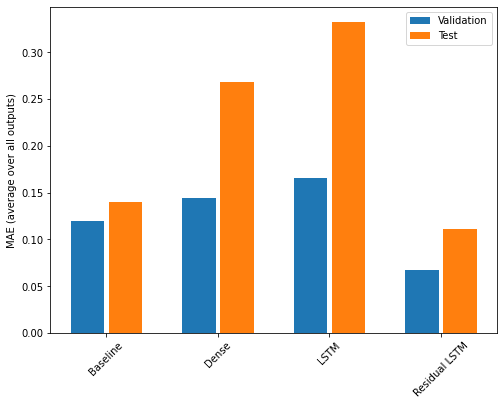

In [33]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [34]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1402
Dense          : 0.2676
LSTM           : 0.3320
Residual LSTM  : 0.1110
